**문제 상황**

와인 병에 인쇄된 알코올도수, 당도, pH 값으로 와인을 구분한다!\
이때, 화이트와인이 어느 것인지 골라내야 한다.

In [1]:
from imblearn.over_sampling     import SMOTENC, SMOTE
from imblearn.pipeline          import Pipeline
from sklearn.decomposition      import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.pipeline           import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_graphviz
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydot
import shap
import xgboost as xgb

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
df = pd.read_csv('https://bit.ly/wine_csv_data')
df.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [4]:
df.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [5]:
df.groupby('class').describe()

alcohol                                                    sugar  \
        count       mean       std  min  25%   50%   75%   max   count   
class                                                                    
0.0    1599.0  10.422983  1.065668  8.4  9.5  10.2  11.1  14.9  1599.0   
1.0    4898.0  10.514267  1.230621  8.0  9.5  10.4  11.4  14.2  4898.0   

                 ...                 pH                                        \
           mean  ...  75%   max   count      mean       std   min   25%   50%   
class            ...                                                            
0.0    2.538806  ...  2.6  15.5  1599.0  3.311113  0.154386  2.74  3.21  3.31   
1.0    6.391415  ...  9.9  65.8  4898.0  3.188267  0.151001  2.72  3.09  3.18   

                   
        75%   max  
class              
0.0    3.40  4.01  
1.0    3.28  3.82  

[2 rows x 24 columns]

불균형 데이터임. 음성 클래스(레드와인)보다 양성 클래스(화이트와인)이 훨씬 많음.

In [6]:
df_x = df.drop(columns='class')
y = df['class']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_x, y, stratify=y, random_state=0)

sm = SMOTE(random_state=0)
X_sm_train, y_sm_train = sm.fit_resample(X_train, y_train)

param_grid = {
    'max_depth': [None, 5, 10],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=0),
    param_grid, scoring='accuracy', cv=5, return_train_score=True)
grid_search.fit(X_sm_train, y_sm_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [None, 5, 10]}, return_train_score=True,
             scoring='accuracy')

(-1.0, 3.0)

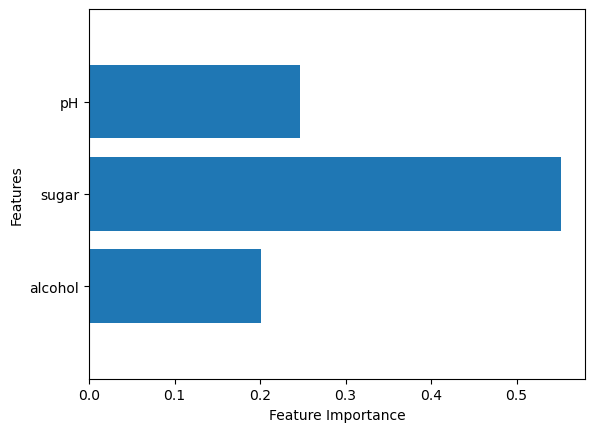

In [8]:
import matplotlib.pyplot as plt
model = grid_search.best_estimator_
n_features = len(df.columns) - 1
plt.barh(np.arange(n_features), model.feature_importances_, align='center')
plt.yticks(np.arange(n_features), df.drop(columns='class').columns)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.ylim(-1, n_features)

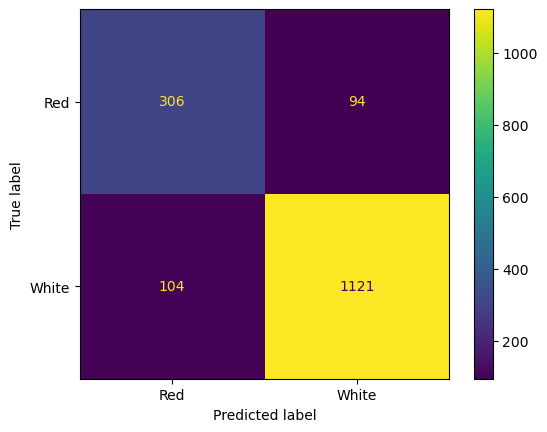

In [9]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Red', 'White'])

In [27]:
xgb_model = xgb.XGBClassifier(max_depth=3, learning_rate=0.2, random_state=0)
xgb_model.fit(X_sm_train, y_sm_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

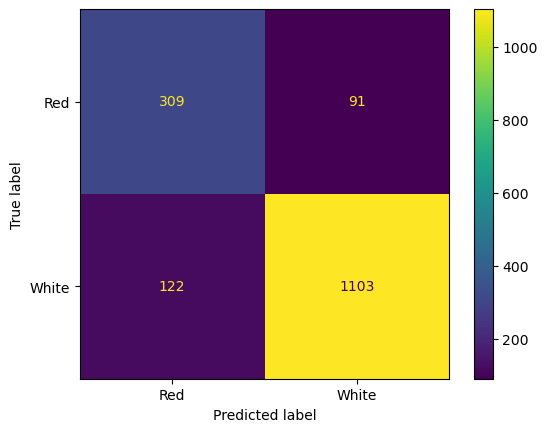

In [28]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['Red', 'White'])

[00:27:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


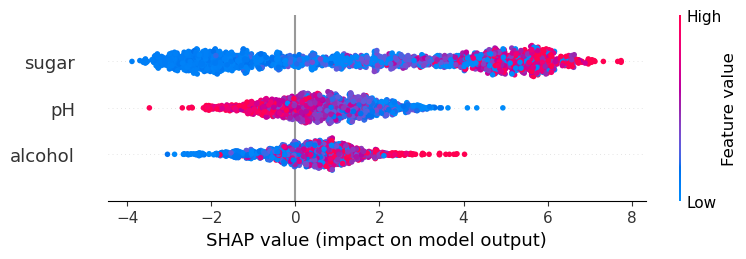

In [15]:
import shap

model = xgb_model
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [16]:
print(X_test.shape)
print(shap_values.shape)
print(shap_values)

(1625, 3)
(1625, 3)
[[-0.4046189   0.9747751  -1.2871614 ]
 [ 0.46993142  3.0249429   1.5334014 ]
 [-0.37929523 -1.415665    1.4460907 ]
 ...
 [ 0.5838917   6.5762815   0.30859932]
 [-0.05818137 -2.4570096   0.9127202 ]
 [ 1.4725252  -1.1966307   2.7644398 ]]


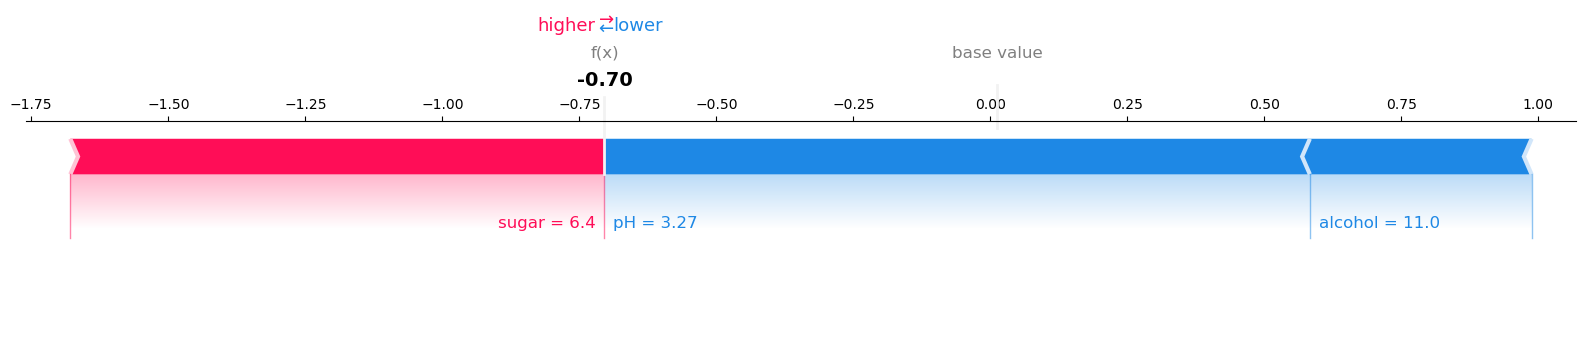

In [17]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True) #about data point 0 

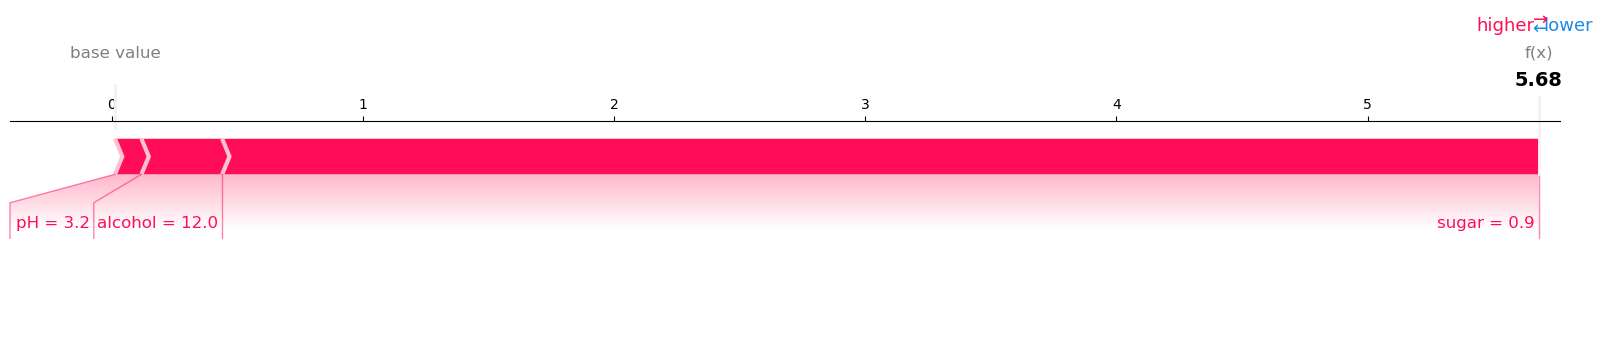

In [18]:
shap.force_plot(explainer.expected_value, shap_values[100,:], X_test.iloc[100,:], matplotlib=True) #about data point 0 

In [26]:
print(model.predict([X_test.iloc[0]]))
print(y_test.iloc[0])
print()
print(model.predict([X_test.iloc[100]]))
print(y_test.iloc[100])

[0]
0.0

[1]
1.0
